In [1]:
# All libs be imported
import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
# All files in src directory
from engine import Engine
from models import UNet, DiffusionLSTM, DiffusionTransformer
from frameworks import Diffusion
from utils import plot_comparison, evaluate_model, visualize_all, plot_loss_comparison, load_checkpoint, plot_series, plot_projection, plot_monte_carlo
from utils.paths import VISUALIZATION_DIR, RESULTS_DIR
from ingestion import read_equity, TSFinDataset
from preprocessing import to_time_bars, to_volume_bars, to_dollar_bars

VISUALIZATION_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
config = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "symbol": "AAPL",
    "target_features": [ "Close", "Volume"], # Can be None
    "seq_length": 64, # window_size
    "batch_size": 64,
    "epochs": 500,
    "lr": 1e-4,      # learning Rate
    "d_model": 128,  # (Hidden size) -> Hidden Dimension of Model
    "layers": 2,      # Deep
    "ddpm": {
        "noise_steps": 1000,
        "beta_start": 1e-4,
        "beta_end": 0.02
    }
}

<Axes: xlabel='Date'>

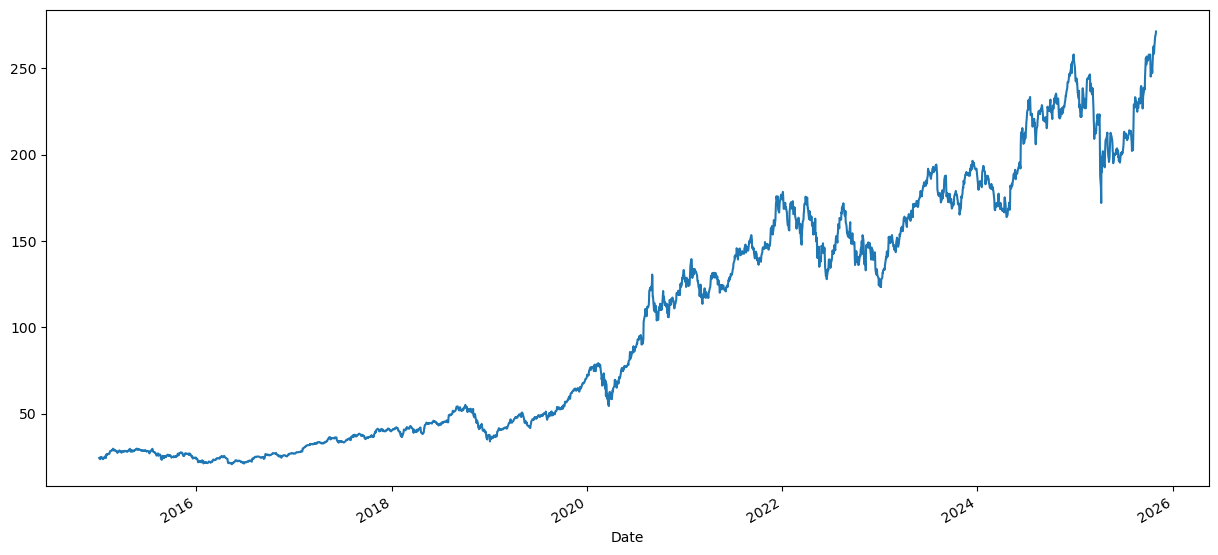

In [4]:
df = read_equity("AAPL")
df.head(3)
df["Close"].plot(figsize=(15, 7))

In [5]:
dataset = TSFinDataset(
    df,
    features=config["target_features"],
    window_size=config["seq_length"],
    use_timestamp=False,
)
input_features = dataset.get_n_features()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
sample_batch = next(iter(dataloader))
print(f"Batch Shape: {sample_batch['x'].shape}")

Batch Shape: torch.Size([32, 64, 2])


In [7]:
model = DiffusionTransformer(
                    features_in=input_features,
                    d_model=128,    # NN Size
                    nhead=4,        # number of Attention Head
                    num_layers=3,   # Deep
                    max_len=config["seq_length"]
                ).to(config["device"])

In [8]:
model_pth = os.path.join(RESULTS_DIR, "checkpoints", "ddpm_diffusiontransformer_0496_20251128_173134.pt")
ckpt = load_checkpoint(model_pth)

try:
    model.load_state_dict(ckpt)
except:
    model.load_state_dict(ckpt["model_state_dict"])

model.eval()

/home/narodom.y@FUSION.LAB/research/src/utils/helper.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


DiffusionTransformer(
  (input_proj): Linear(in_features=2, out_features=128, bias=True)
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.

In [9]:
optimizer = optim.AdamW(model.parameters(), lr=config["lr"]) 
diffusion = Diffusion(
    noise_steps = config["ddpm"]["noise_steps"],
    beta_start = config["ddpm"]["beta_start"],
    beta_end = config["ddpm"]["beta_end"],
    length= config["seq_length"],
    channels= input_features,
    device = config["device"]
)

# engine = Engine(dataloader, diffusion, model, optimizer, device=config["device"])
# engine.fit(epochs=config["epochs"])

In [10]:
batch = next(iter(dataloader))
batch["x"].shape

torch.Size([32, 64, 2])

In [11]:
one_sample = batch["x"][0]
hist_series = one_sample.cpu().numpy()
horizon = 16
hist_part, forecasted_part = diffusion.sample_forecast(
    model= model,
    hist_series= hist_series,
    horizon= horizon
)


1000it [00:03, 258.15it/s]


In [12]:
hist_part.shape

(48, 2)

In [13]:
forecasted_part.shape

(16, 2)

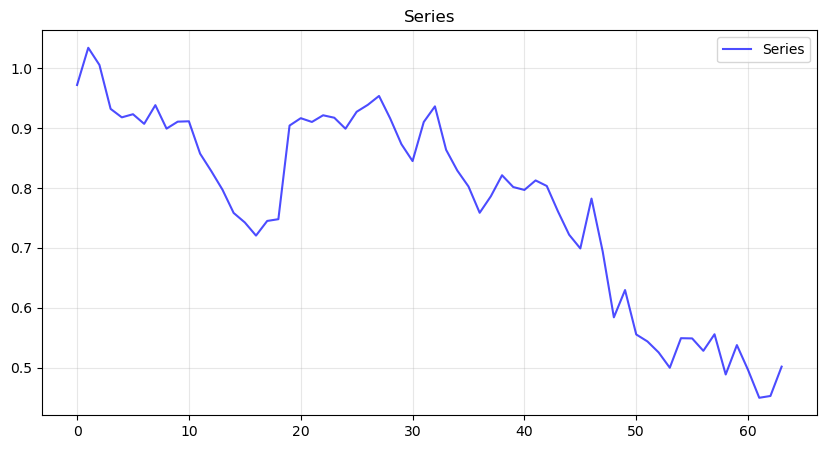

In [14]:
plot_series(x=np.concatenate([hist_part[:, 0], forecasted_part[:, 0]]))

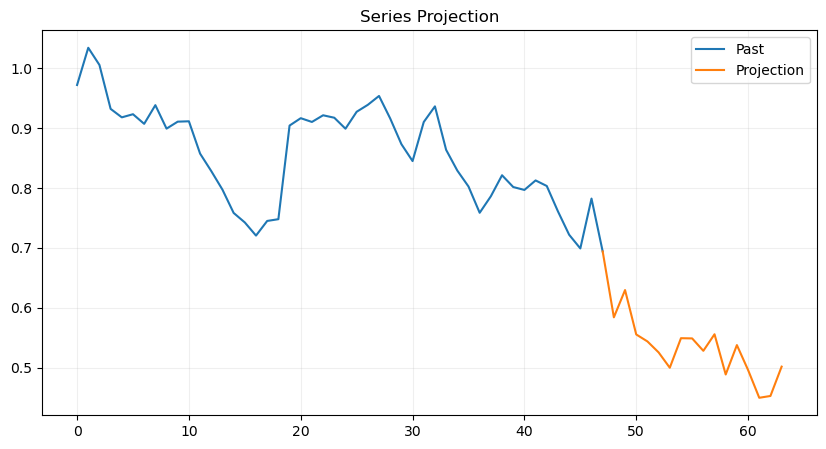

In [15]:
# x = np.concatenate([hist_part[:, 0], forecasted_part[:, 0]])
plot_projection(hist_part, forecasted_part, col=0)

In [16]:
n_simulations = 500
mc_forecasts = []

print(f"Starting Monte Carlo Simulation ({n_simulations} runs)...")

for i in range(n_simulations):
    _, forecast = diffusion.sample_forecast(
        model=model,
        hist_series=hist_series,
        horizon=horizon
    )
    mc_forecasts.append(forecast)

all_scenarios = np.array(mc_forecasts)
print("Simulation Complete:", all_scenarios.shape)

Starting Monte Carlo Simulation (500 runs)...


1000it [00:03, 295.26it/s]
1000it [00:03, 295.07it/s]
1000it [00:03, 294.93it/s]
1000it [00:03, 295.50it/s]
1000it [00:03, 294.72it/s]
1000it [00:03, 296.41it/s]
1000it [00:03, 295.51it/s]
1000it [00:03, 295.20it/s]
1000it [00:03, 295.39it/s]
1000it [00:03, 295.11it/s]
1000it [00:03, 294.13it/s]
1000it [00:03, 296.62it/s]
1000it [00:03, 295.47it/s]
1000it [00:03, 296.74it/s]
1000it [00:03, 296.47it/s]
1000it [00:03, 294.67it/s]
1000it [00:03, 294.28it/s]
1000it [00:03, 295.78it/s]
1000it [00:03, 295.50it/s]
1000it [00:03, 295.99it/s]
1000it [00:03, 296.19it/s]
1000it [00:03, 294.75it/s]
1000it [00:03, 296.32it/s]
1000it [00:03, 296.88it/s]
1000it [00:03, 295.66it/s]
1000it [00:03, 295.31it/s]
1000it [00:03, 295.80it/s]
1000it [00:03, 295.09it/s]
1000it [00:03, 293.11it/s]
1000it [00:03, 295.40it/s]
1000it [00:03, 294.94it/s]
1000it [00:03, 294.36it/s]
1000it [00:03, 296.00it/s]
1000it [00:03, 294.71it/s]
1000it [00:03, 294.94it/s]
1000it [00:03, 295.69it/s]
1000it [00:03, 295.00it/s]
1

Simulation Complete: (500, 16, 2)


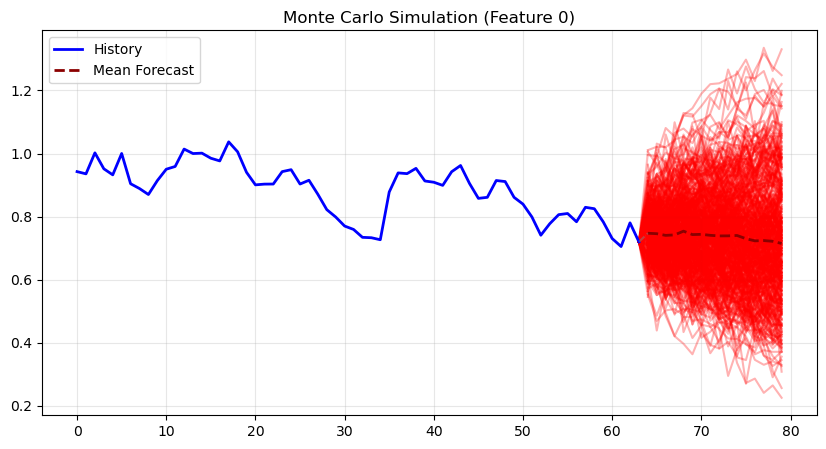

In [17]:
plot_monte_carlo(hist_series, all_scenarios, feature_idx=0)